# Лабораторная работа №4 по дисциплине "Математические методы цифровой обработки сигналов"

# Тема: Алгоритм Карплуса-Стронга

#### Выполнил магистрант гр. 9385, Семенов Александр.

## Постановка задачи
**Цель работы:**  исследовать работу алгоритма Карплуса-Стронга на различных аккордах с различными параметрами.

**Задачи работы:**
1) Реализовать базовый алгоритм Карплуса-Стронга;
2) Провести эксперименты с различным выбором начальной последовательности;
3) Провести эксперименты с модификациями алгоритма Карплуса-Стронга;
4) Реализовать выбранное трезвучие из таблицы 1.

## Генерация аккордов

1. В качестве базовой частоты $f_0$ берем $130.82\;Гц\;-$ до малой октавы.
2. Нота с номером $k$ вычисляется по формуле: $f_k=f_0*2^{\frac{k}{12}},\;k=1,2,...$
3. Мажорные и минормные аккорды состоят из трех звуков. В таблице 1 представлены основные аккорды:

|Тональность|Номера нот|Тональность|Номера нот|
|:-:|:-:|:-:|:-:|
|До мажор|{0, 4, 7}|До диез минор|{1, 4, 8}|
|До диез мажор|{1, 5, 8}|Ре минор|{2, 5, 9}|
|Ре мажор|{2, 6, 9}|Ре диез минор|{3, 6, 9}|
|Ре диез мажор|{3, 7, 10}|Ми минор|{4, 7, 11}|
|Ми мажор|{4, 8, 11}|Фа диез минор|{6, 9, 13}|
|Фа мажор|{5, 9, 12}|Соль диез минор|{8, 11, 15}|
|Фа диез мажор|{6, 10, 13}|Ля минор|{9, 13, 16}|
|Соль диез мажор|{8, 12, 15}|Си минор|{11, 14, 18}|
|Ля диез мажор|{10, 14, 15}||

_Таблица 1_

## Выполнение работы

### 1. Инициализация параметров и функции отрисовки осцилограммы:

In [12]:
import librosa
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import soundfile as sf
import numpy as np

f0 = 130.82
fd = 16000
note_duration = 3 # sec
note_delay_size = int(0.1 * fd)


def paintGraphics(data, framerate, b, a = 0):
    # a - Правая граница
    # b - Левая граница

    N = b - a # Вычисляем количество точек осциллограммы сигнала
    n = 400 # Задаем количество точек огибающей
    m = int(N/n) # Вычисляем число точек в интервале усреднения
    x = data[a:b] # Строим массив значений осциллограммы сигнала
    y = [np.mean([abs(x[k]) for k in range(m*j, m*(j+1))]) for j in range(n)] # Строим список значений огибающей

    timeSignal = np.arange(a, b) / framerate # Строим массив точек времени для осциллограммы сигнала
    timeOgib = np.arange(a, m*n + a, m) / framerate # Строим массив точек времени для огибающей

    plt.figure(figsize = [15, 15])
    plt.plot(timeSignal, x, color = 'blue',  linewidth = 0.3, label = "Осциллограмма сигнала") # Строим осциллограмму сигнала
    plt.plot(  timeOgib, y, color = 'red',   linewidth = 1.5, label = "Огибающая") # Строим огибающую
    plt.legend()
    plt.xlabel("time (seconds)")
    plt.title("Осциллограмма сигнала и огибающая")
    plt.grid()

    plt.show()

### 2. Реализация алгоритма:

In [13]:
def karplus_strong(fd, fs, raspred, attenuation, alpha):
    N = int(fd / fs - 1/2)
    note_size = fd * note_duration
    
    y = np.zeros(note_size)
    y[-1] = 0

    y[0:N] =  np.random.normal(0, 1, N) if raspred == 'norm' else np.random.uniform(-1, 1, N)

    for n in range(N, note_size):
        if alpha is None:
            y[n] = attenuation * 0.5 * (y[n - N] + y[n - N - 1])
        else:
            y[n] = attenuation * 0.5 * ((1 - alpha) * y[n - N] + alpha * y[n - N - 1])

    return y

### 3. Тестирование:

##### a) По коэффициентам затухания:

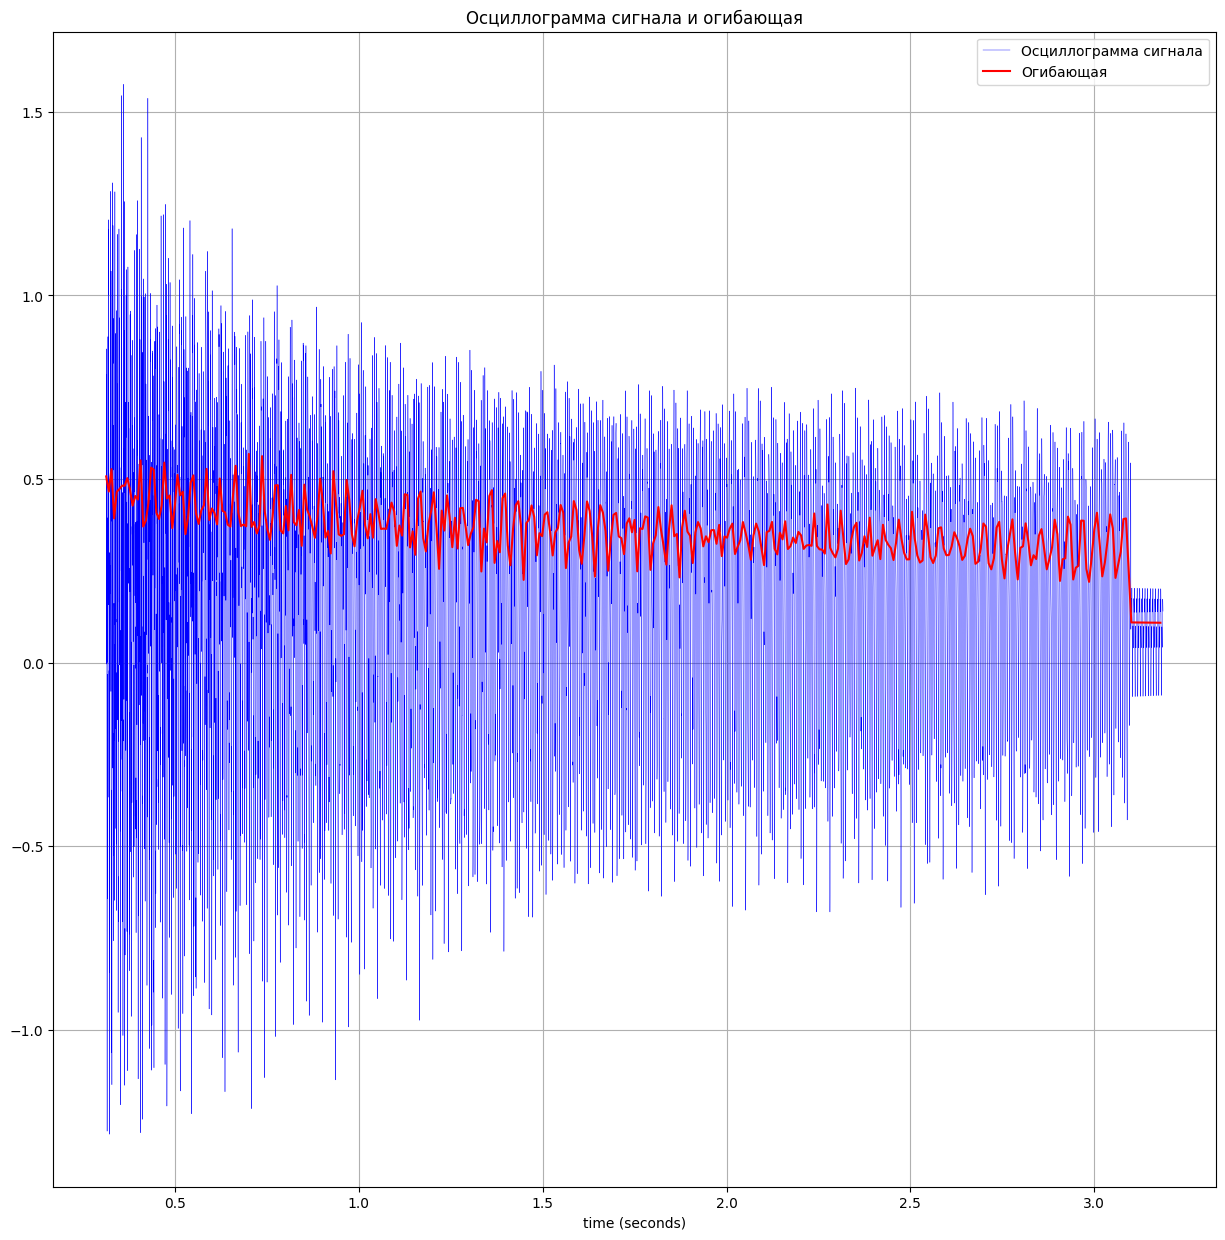

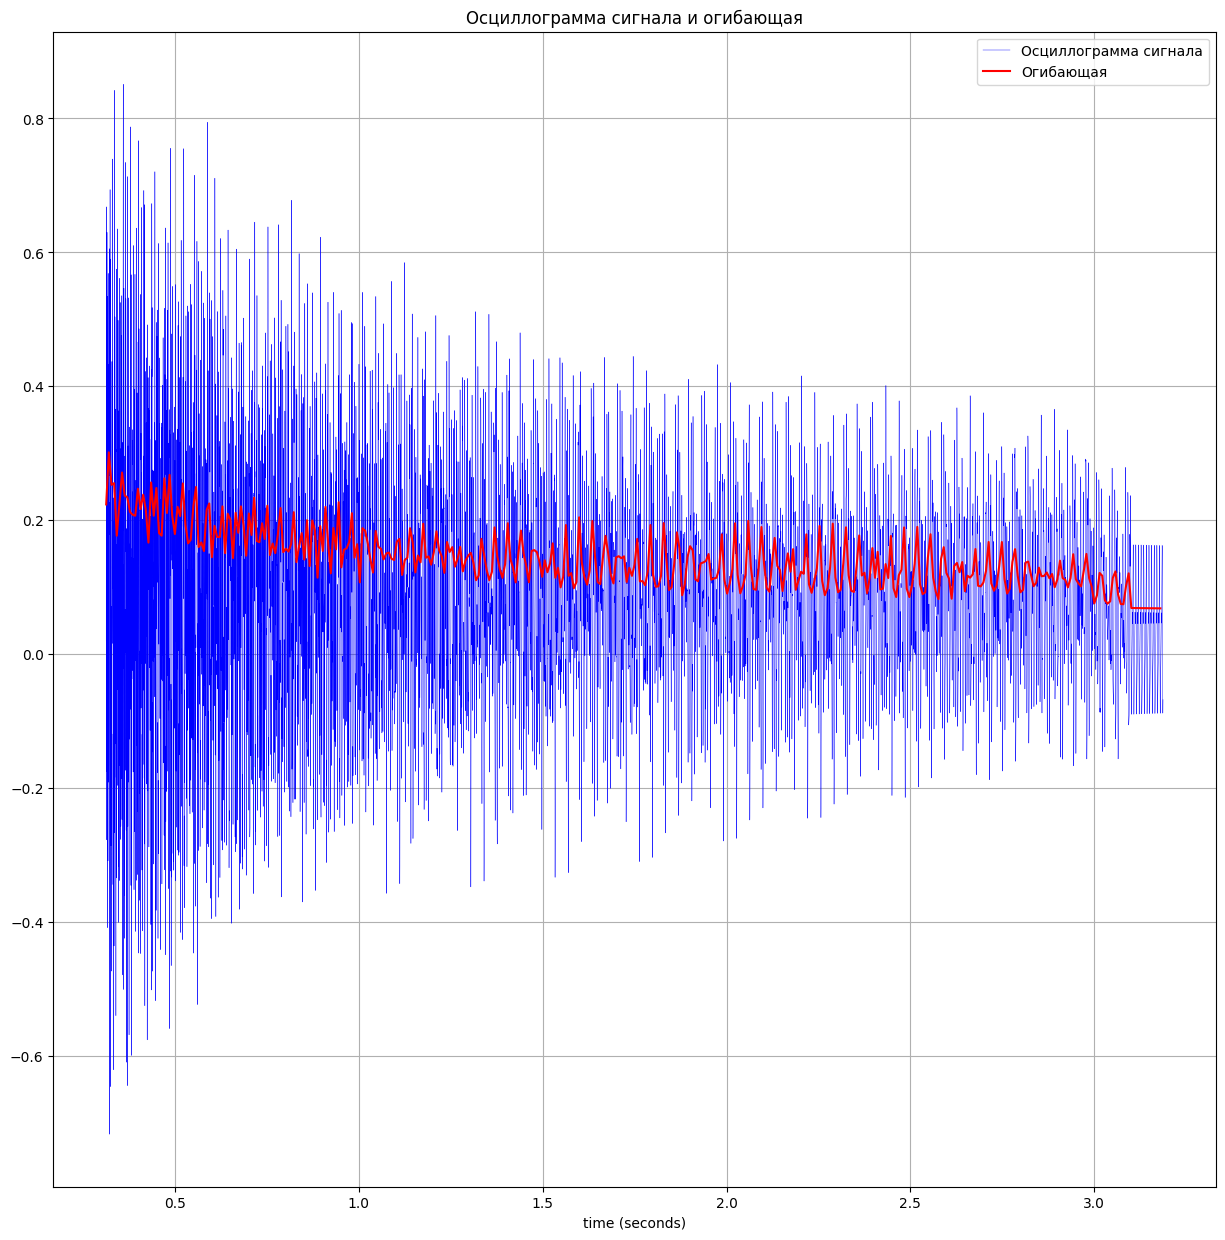

In [24]:
for raspred in ('norm', 'uni'):
    notes = np.array([7, 4, 1])
    attenuation = 1
    alpha = None

    note_size = fd * note_duration
    chord_size = int((notes.size - 1) * note_delay_size + note_size)
    chord = np.zeros((notes.size, chord_size))

    for i in range(notes.size):
        fk = f0 * 2 ** (notes[i] / 12)
        chord[
            i, 
            i * note_delay_size : chord_size - (notes.size - 1 - i) *  note_delay_size
        ] = karplus_strong(fd, fk, raspred, attenuation, alpha)[-note_size:]

    sound = np.sum(chord, axis=0)
    sf.write(f'chord_attenuation_{raspred}.wav', sound, fd)

    paintGraphics(sound, fd, 51000, 5000)